## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Managament](#2)
    -  [2.1.Downloading , Extracting and Spliting Dataset](#2.1)
    -  [2.2.Pytorch Dataset](#2.2)
    -  [2.3.Pytorch DataLoaders](#2.3)
-  [3.Initializing pre-trained model](#3)
-  [4.Training](#4)
-  [5.Plotting Graphs](#5)
    -  [5.1.Plotting Loss vs Epoch](#5.1)
    -  [5.2.Plotting Accuracy vs Epoch](#5.2)
-  [6.Loading and Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import wget
import tarfile
import os
import math
import torchvision.transforms as T

sns.set_style("darkgrid")

### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading , Extracting and Spliting Dataset <a class="anchor" id="2.1"></a>

In [2]:
zip_file_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
#check if the zipfile already exists

if "images.tar" not in os.listdir() :
    wget.download('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar')
    
#check if the zip file is extracted

if len(os.listdir("data/"))== 0:

    # open file
    file = tarfile.open('images.tar')
  
    # extracting file
    file.extractall('data/')
    print("Extraction completed")
    file.close()
     
    # creating train , test and validation folders
    path = "data/"
    classes = os.listdir(path+'/images')
    os.mkdir("data/train")
    os.mkdir("data/test")
    os.mkdir("data/validation")
            
    for i in classes:
        os.mkdir('data/train/'+i)
        os.mkdir('data/test/'+i)
        os.mkdir('data/validation/'+i)
    
    # (class_n , images_name) storing all the image name/location
    images_path = []
    for i in classes:
        temp = []
        for j in os.listdir(path+'images/'+i+'/'):
            temp.append(j)
        images_path.append(temp)
    
    # splitting train , test and validation images for each classes
    
    train = 0.9
    test = 0.075
    validatiation = 0.025

    train_img_path = []
    test_img_path = []
    validation_img_path = []

    for i in images_path:
        n = len(i)
        train_n = int(train*n)
        test_n = int(test*n)
        validation_n = n - train_n - test_n
    
        train_img_path.append(i[:train_n])
        test_img_path.append(i[train_n:test_n+train_n])
        validation_img_path.append(i[train_n+test_n:])
    
    # Moving corresponding images to the train , test and validation folders

    for i,class_name in zip(train_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"train/"+class_name+"/"+j)
        
    for i,class_name in zip(test_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"test/"+class_name+"/"+j)
        
    for i,class_name in zip(validation_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"validation/"+class_name+"/"+j)
            

#### 2.Pytorch Dataset <a class="anchor" id="2.2"></a>

In [3]:
import requests , io
import os

class Dataset(Dataset):
    def __init__(self , type = 'train' , transform = 'T.Resize((256,256))'):
        self.x = []
        self.y = []
        self.transform = transform
        self.n_classes = len(os.listdir('data/train/'))
        if type == 'train':
            path = 'data/train/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)

        if type == 'test':
            path = 'data/test/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)
                    
        if type == 'validation':
            path = 'data/validation/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)
                    
        self.len = len(self.x)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        image = self.transform(Image.fromarray(np.asarray(Image.open(self.x[i]))[:,:,:3]))
        x = torch.FloatTensor(np.asarray(image))
        return x,torch.LongTensor([self.y[i]])
    


#### 3.Pytorch DataLoaders <a class="anchor" id="2.3"></a>

In [4]:
batch_size = 16
classes = os.listdir('data/train/')
n_classes = len(classes)

transforms_train = T.Compose([
        T.Resize((224,224)),
        T.RandomRotation(degrees=30),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_dataset = Dataset('train',transform =transforms_train )
test_dataset = Dataset('test',transform =transforms_test )
validation_dataset = Dataset('validation',transform =transforms_test )

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size)

### 3.Initializing pre-trained model <a class="anchor" id="3"></a>

In [5]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False                     # Freezing the model parameters that isn't required to be trained
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)

# for name,child in model.named_children():
#     print(name,child)

# class extended_model(nn.Module):
#     def __init__(self,pretrained_model):
#         super().__init__()
#         self.pretrained_model = pretrained_model     #Pretrained models can be extended this way
        
#     def forward(self,x):
#         x = self.pretrained_model(x)
#         x = F.softmax(x)
#         return x

# model = extended_model(model)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 4.Training <a class="anchor" id="4"></a>

In [6]:
lr = 0.01
epoch = 15
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [7]:
for e in range(epoch):
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % 100 == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),'saved_model/resnet50_v1')
    
    #Log for e+1th epoch
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    n_validation_losses = int(train_n_minibatches/100)*validation_n_minibatches
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}',end = ' ')
    print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}')
    print('---------------------------------------------------------------------------------------------')

LOSS for EPOCH 1 BATCH 0/1155 TRAIN LOSS : 4.9398908615112305 TRAIN ACCURACY : 0.0 VALIDATION LOSS : 4.8720204591751095 VALIDATION ACCURACY : 0.78125
LOSS for EPOCH 1 BATCH 100/1155 TRAIN LOSS : 4.5158772468566895 TRAIN ACCURACY : 0.0 VALIDATION LOSS : 4.301684910058976 VALIDATION ACCURACY : 13.28125
LOSS for EPOCH 1 BATCH 200/1155 TRAIN LOSS : 3.897536277770996 TRAIN ACCURACY : 31.25 VALIDATION LOSS : 3.823131251335144 VALIDATION ACCURACY : 24.0625
LOSS for EPOCH 1 BATCH 300/1155 TRAIN LOSS : 3.7879326343536377 TRAIN ACCURACY : 25.0 VALIDATION LOSS : 3.39531369805336 VALIDATION ACCURACY : 38.90625
LOSS for EPOCH 1 BATCH 400/1155 TRAIN LOSS : 3.360856294631958 TRAIN ACCURACY : 25.0 VALIDATION LOSS : 3.006963860988617 VALIDATION ACCURACY : 49.6875
LOSS for EPOCH 1 BATCH 500/1155 TRAIN LOSS : 2.779902935028076 TRAIN ACCURACY : 56.25 VALIDATION LOSS : 2.6652338802814484 VALIDATION ACCURACY : 52.65625
LOSS for EPOCH 1 BATCH 600/1155 TRAIN LOSS : 2.6920766830444336 TRAIN ACCURACY : 56.25 VA

LOSS for EPOCH 4 BATCH 1000/1155 TRAIN LOSS : 1.0512369871139526 TRAIN ACCURACY : 81.25 VALIDATION LOSS : 0.789505410194397 VALIDATION ACCURACY : 77.65625
LOSS for EPOCH 4 BATCH 1100/1155 TRAIN LOSS : 1.410088062286377 TRAIN ACCURACY : 62.5 VALIDATION LOSS : 0.7944278564304114 VALIDATION ACCURACY : 78.125
---------------------------------------EPOCH 4-------------------------------------------
Loss for EPOCH 4  TRAIN LOSS : 1.0864785180979477 TRAIN ACCURACY : 73.06818181818181
VALIDATION LOSS for EPOCH 4 : 0.8170376085760919 VALIDATION ACCURACY : 77.40056818181819
---------------------------------------------------------------------------------------------
LOSS for EPOCH 5 BATCH 0/1155 TRAIN LOSS : 1.3517186641693115 TRAIN ACCURACY : 56.25 VALIDATION LOSS : 0.7964604862034321 VALIDATION ACCURACY : 80.15625
LOSS for EPOCH 5 BATCH 100/1155 TRAIN LOSS : 1.0250182151794434 TRAIN ACCURACY : 68.75 VALIDATION LOSS : 0.788381428271532 VALIDATION ACCURACY : 77.1875
LOSS for EPOCH 5 BATCH 200/11

LOSS for EPOCH 8 BATCH 600/1155 TRAIN LOSS : 0.9198978543281555 TRAIN ACCURACY : 81.25 VALIDATION LOSS : 0.7139200676232577 VALIDATION ACCURACY : 77.96875
LOSS for EPOCH 8 BATCH 700/1155 TRAIN LOSS : 0.9367157220840454 TRAIN ACCURACY : 81.25 VALIDATION LOSS : 0.7041053915396333 VALIDATION ACCURACY : 80.0
LOSS for EPOCH 8 BATCH 800/1155 TRAIN LOSS : 0.6045886278152466 TRAIN ACCURACY : 87.5 VALIDATION LOSS : 0.6682798281311989 VALIDATION ACCURACY : 80.3125
LOSS for EPOCH 8 BATCH 900/1155 TRAIN LOSS : 0.8025904893875122 TRAIN ACCURACY : 81.25 VALIDATION LOSS : 0.7126041483134031 VALIDATION ACCURACY : 80.0
LOSS for EPOCH 8 BATCH 1000/1155 TRAIN LOSS : 1.6632215976715088 TRAIN ACCURACY : 43.75 VALIDATION LOSS : 0.7029670726507902 VALIDATION ACCURACY : 79.6875
LOSS for EPOCH 8 BATCH 1100/1155 TRAIN LOSS : 0.8616142272949219 TRAIN ACCURACY : 75.0 VALIDATION LOSS : 0.6856801142916084 VALIDATION ACCURACY : 80.3125
---------------------------------------EPOCH 8-----------------------------------

LOSS for EPOCH 12 BATCH 200/1155 TRAIN LOSS : 0.47091010212898254 TRAIN ACCURACY : 87.5 VALIDATION LOSS : 0.6439166467636823 VALIDATION ACCURACY : 80.78125
LOSS for EPOCH 12 BATCH 300/1155 TRAIN LOSS : 0.8135905265808105 TRAIN ACCURACY : 81.25 VALIDATION LOSS : 0.6906504213809967 VALIDATION ACCURACY : 79.375
LOSS for EPOCH 12 BATCH 400/1155 TRAIN LOSS : 1.1357238292694092 TRAIN ACCURACY : 75.0 VALIDATION LOSS : 0.6768831703811884 VALIDATION ACCURACY : 80.0
LOSS for EPOCH 12 BATCH 500/1155 TRAIN LOSS : 0.9494622945785522 TRAIN ACCURACY : 81.25 VALIDATION LOSS : 0.6588226433843374 VALIDATION ACCURACY : 79.6875
LOSS for EPOCH 12 BATCH 600/1155 TRAIN LOSS : 0.5908036231994629 TRAIN ACCURACY : 87.5 VALIDATION LOSS : 0.6745120696723461 VALIDATION ACCURACY : 78.90625
LOSS for EPOCH 12 BATCH 700/1155 TRAIN LOSS : 0.9192638993263245 TRAIN ACCURACY : 75.0 VALIDATION LOSS : 0.6630229020491243 VALIDATION ACCURACY : 81.25
LOSS for EPOCH 12 BATCH 800/1155 TRAIN LOSS : 0.6883998513221741 TRAIN ACCURA

### 5.Plotting Graphs<a class="anchor" id="5"></a>

#### 1.Plotting Loss vs Epoch<a class="anchor" id="5.1"></a>

c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


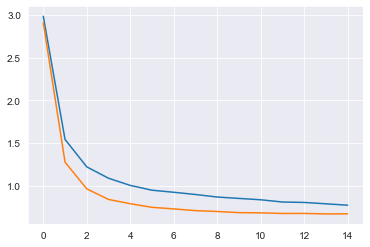

In [8]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(range(len(loss_per_epoch[0])),loss_per_epoch[0])
sns.lineplot(range(len(loss_per_epoch[1])),loss_per_epoch[1])
plt.show()

#### 2.Plotting Accuracy vs Epoch<a class="anchor" id="5.2"></a>

c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


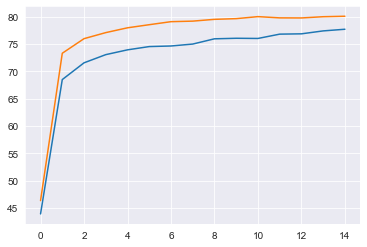

In [9]:
# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(range(len(accuracy_per_epoch[0])),accuracy_per_epoch[0])
sns.lineplot(range(len(accuracy_per_epoch[1])),accuracy_per_epoch[1])
plt.show()

### 6.Loading and Testing<a class="anchor" id="6"></a>

In [10]:
#Loading the saved model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
model.load_state_dict(torch.load('saved_model/resnet50_v1', map_location='cpu'))
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
#Displaying the model summary
from torchsummary import summary
summary(model, (3,224,224), batch_size=16, device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]           4,096
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          16,384
      BatchNorm2d-12          [16, 256, 56, 56]             512
           Conv2d-13          [16, 256, 56, 56]          16,384
      BatchNorm2d-14          [16, 256,

In [12]:
test_loss_history = []
test_accuracy_history = []

In [13]:
#Testing the model on test dataset
model = model.to('cpu')
model.eval()
for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    y_pred = model(x)
    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0
    y_pred = y_pred.detach().numpy().tolist()
    y = y.detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)
                        
print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')                    

LOSS : 0.6438697055783323  ACCURACY : 80.26881720430107
